In [1]:
# Import required libraries
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
print(rdkit.__version__)

2024.09.3


In [2]:
# Part 1: Different Line Notations
# SMILES examples
aspirin_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"
caffeine_smiles ="CN1C=NC2=C1C(=O)N(C(=O)N2C)C"
paracetamol_smiles = "CC(=O)NC1=CC=C(O)C=C1"
benzen_smiles = "c1ccccc1"

In [3]:
# Convert SMILES to molecules
aspirin_mol = Chem.MolFromSmiles(aspirin_smiles)
caffeine_mol = Chem.MolFromSmiles(caffeine_smiles)
paracetamol_mol = Chem.MolFromSmiles(paracetamol_smiles)
benzene_mol = Chem.MolFromSmiles(benzen_smiles)

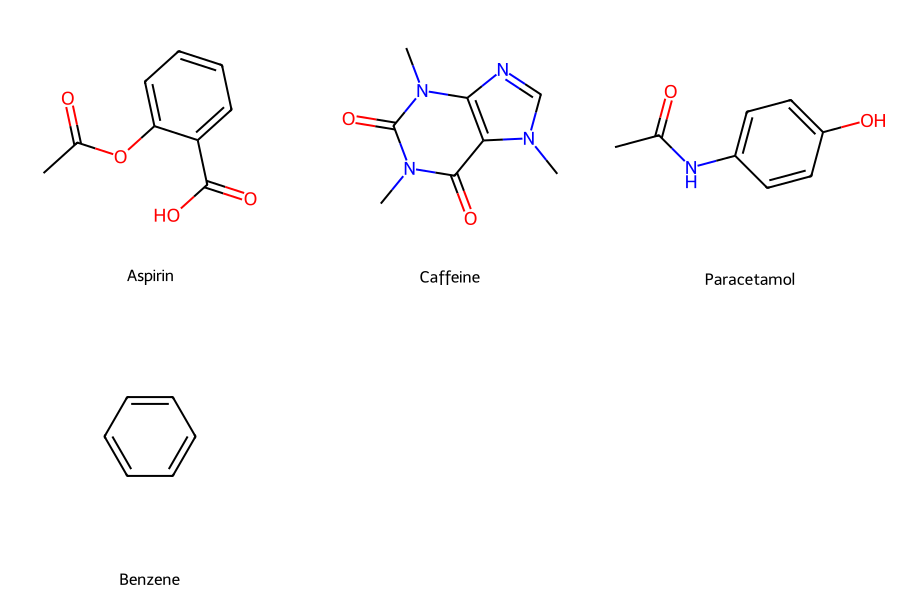

In [ ]:
# Part 2: Visualizing Molecules
# Create a list of molecules and their names

mols = [aspirin_mol, caffeine_mol, paracetamol_mol, benzene_mol]
legends = ['Aspirin', 'Caffeine', 'Paracetamol', 'Benzene']

# Draw molecules in a grid

img = Draw.MolsToGridImage(mols, legends=legends, molsPerRow=3, subImgSize=(300,300), returnPNG=False)
img

In [5]:
# Part 3
def calculate_properties(mol):
    """
    Calculates basic molecular properties and descriptors for a given molecule.
    
    Computes a set of commonly used molecular descriptors that are relevant for 
    drug discovery and chemical analysis:
    - Molecular Weight: Exact molecular weight in daltons
    - LogP: Octanol-water partition coefficient (lipophilicity measure)
    - H-Bond Donors: Number of hydrogen bond donors (OH and NH groups)
    - H-Bond Acceptors: Number of hydrogen bond acceptors (O and N atoms)
    - Rotatable Bonds: Number of rotatable bonds (flexibility measure)
    - Ring Count: Number of rings in the molecule
    - TPSA: Topological Polar Surface Area (membrane permeability indicator)
    
    Parameters
    ----------
    mol : rdkit.Chem.rdchem.Mol
        RDKit molecule object to analyze
        
    Returns
    -------
    dict
        Dictionary containing calculated properties:
        - Molecular Weight: float
        - LogP: float
        - H-Bond Donors: int
        - H-Bond Acceptors: int
        - Rotatable Bonds: int
        - Ring Count: int
        - TPSA: float (in Å²)
    
    Examples
    --------
    >>> from rdkit import Chem
    >>> aspirin = Chem.MolFromSmiles("CC(=O)OC1=CC=CC=C1C(=O)O")
    >>> calculate_properties(aspirin)
    {'Molecular Weight': 180.157, 'LogP': 1.31, 'H-Bond Donors': 1,
     'H-Bond Acceptors': 4, 'Rotatable Bonds': 3, 'Ring Count': 1,
     'TPSA': 63.6}
    """

    
    return {
            "Molecular Weight": Descriptors.ExactMolWt(mol),
            "LogP": Descriptors.MolLogP(mol),
            "H-bond Donors": Descriptors.NumHDonors(mol),
            "H-bond Acceptors": Descriptors.NumHAcceptors(mol),
            "Rotatable Bonds": Descriptors.NumRotatableBonds(mol),
            "Ring Count": Descriptors.RingCount(mol),
            "TPSA": Descriptors.TPSA(mol)
    }

In [6]:
# Calculate properties for each molecule
properties_list = []
for mol, name in zip(mols, legends):
    props = calculate_properties(mol)
    props['Name'] = name
    properties_list.append(props)

In [7]:
# Convert to DataFrame
df = pd.DataFrame(properties_list)
df = df.set_index('Name')
df

,Molecular Weight,LogP,H-bond Donors,H-bond Acceptors,Rotatable Bonds,Ring Count,TPSA
Name,,,,,,,
Aspirin,180.042259,1.3101,1,3,2,1,63.60
Caffeine,194.080376,-1.0293,0,6,0,2,61.82
Paracetamol,151.063329,1.3506,2,2,1,1,49.33
Benzene,78.046950,1.6866,0,0,0,1,0.00


In [8]:
# Part 4: More Advanced Descriptors - Morgan Fingerprints
def generate_morgan_fingerprint(mol, radius=2, nbits=1024):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nbits)

In [9]:
# Generate fingerprints for each molecule
fingerprints =[]
for mol in mols:
    fp = generate_morgan_fingerprint(mol)
    fingerprints.append(list(fp.ToBitString()))

[23:52:07] DEPRECATION WARNING: please use MorganGenerator
[23:52:07] DEPRECATION WARNING: please use MorganGenerator
[23:52:07] DEPRECATION WARNING: please use MorganGenerator
[23:52:07] DEPRECATION WARNING: please use MorganGenerator


In [10]:
# Convert fingerprints to numpy array
fp_array = np.array(fingerprints, dtype=int)
print(fp_array)
print(len(fp_array[0]))

[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
1024


In [11]:
# Part 5: Simple Analysis - PCA of Fingerprints
pca = PCA(n_components=2)
fp_pca = pca.fit_transform(fp_array)

Text(0.5, 1.0, 'PCA of Morgan Fingerprints')

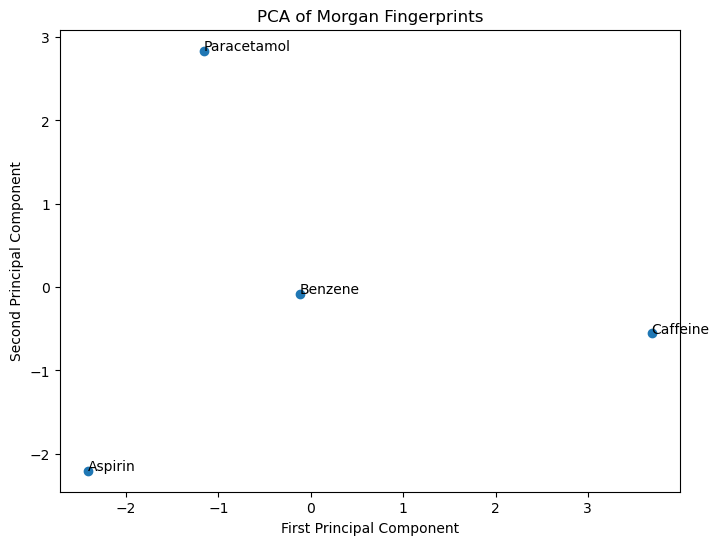

In [12]:
# Plot PCA results
plt.figure(figsize=(8, 6))
plt.scatter(fp_pca[:, 0], fp_pca[:, 1])
for i, name in enumerate(legends):
    plt.annotate(name, (fp_pca[i, 0], fp_pca[i, 1]))
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Morgan Fingerprints')

In [13]:
def check_lipinski(mol):
    """
    Evaluates Lipinski's Rule of 5 for drug-likeness of a molecule.
    
    Lipinski's rules state that drug-like molecules generally have:
    - Molecular weight ≤ 500 daltons
    - Octanol-water partition coefficient (LogP) ≤ 5
    - Hydrogen bond donors ≤ 5 (OH and NH groups)
    - Hydrogen bond acceptors ≤ 10 (oxygen and nitrogen atoms)
    A molecule is considered likely to be drug-like if it violates no more than one rule.
    
    Parameters
    ----------
    mol : rdkit.Chem.rdchem.Mol
        RDKit molecule object to evaluate
        
    Returns
    -------
    dict
        Dictionary containing:
        - Molecular Weight: float
        - LogP: float
        - H-Bond Donors: int
        - H-Bond Acceptors: int
        - Violations: int (number of Lipinski rules violated)
        - Passes Rule of 5: bool (True if 1 or fewer violations)
    
    Examples
    --------
    >>> from rdkit import Chem
    >>> aspirin = Chem.MolFromSmiles("CC(=O)OC1=CC=CC=C1C(=O)O")
    >>> check_lipinski(aspirin)
    {'Molecular Weight': 180.157, 'LogP': 1.31, 'H-Bond Donors': 1, 
     'H-Bond Acceptors': 4, 'Violations': 0, 'Passes Rule of 5': True}
    """

    
    mw = Descriptors.ExactMolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    
    violations = 0
    if mw > 500: violations += 1
    if logp > 5: violations += 1
    if hbd > 5: violations += 1
    if hba > 10: violations += 1
    
    return {
        'Molecular Weight': mw,
        'LogP': logp,
        'H-Bond Donors': hbd,
        'H-Bond Acceptors': hba,
        'Violations': violations,
        'Passes Rule of 5': violations <= 1
    }

In [14]:
# Check Lipinski's rules for each molecule
lipinski_results = []
for mol, name in zip(mols, legends):
    results = check_lipinski(mol)
    results['Name'] = name
    lipinski_results.append(results)

In [15]:
lipinski_df = pd.DataFrame(lipinski_results)
lipinski_df = lipinski_df.set_index('Name')
lipinski_df

,Molecular Weight,LogP,H-Bond Donors,H-Bond Acceptors,Violations,Passes Rule of 5
Name,,,,,,
Aspirin,180.042259,1.3101,1,3,0,True
Caffeine,194.080376,-1.0293,0,6,0,True
Paracetamol,151.063329,1.3506,2,2,0,True
Benzene,78.046950,1.6866,0,0,0,True
